In [1]:
import sys
import sklearn

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

import numpy as np
import os
from pathlib import Path

from tensorflow.keras.utils import plot_model

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)

# **Preliminaries**

In [2]:
def plot_series(series, y = None, y_pred = None, x_label = '$t$', y_label = '$x(t)$'):
  n_steps = series.shape[0]
  plt.plot(series, ".-", label = 'x')
  if y is not None:
    plt.plot(n_steps, y, 'bx', label = "actual y", markersize = 10)
  if y_pred is not None:
    plt.plot(n_steps, y_pred, 'ro', label = "predicted y")
  plt.grid(True)
  if x_label:
    plt.xlabel(x_label, fontsize = 16)
  if y_label:
    plt.ylabel(y_label, fontsize = 16, rotation = 0)
  plt.hlines(0, 0, 100, linewidth = 1)
  plt.axis([0, n_steps + 1, None, None])
  plt.legend()

In [ ]:
def plot_multiple_forecast(X, Y, Y_pred):
  n_steps = X.shape[1]
  ahead = Y.shape[1]
  plot_series(X[0, :, 0])
  plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], 'bx-', label = "Actual")
  plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], 'ro-', label = "Forecast", markersize = 10)
  plt.axis([0, n_steps + ahead, None, None])
  plt.legend(fontsize = 14)
  

In [ ]:
def plot_learning_curves(loss, val_loss):
  plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label = "Training loss")
  plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label = "Validation loss")
  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer = True))
  plt.axis([1, 20, None, None])
  plt.legend(fontsize = 14)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.grid(True)

In [ ]:
def generate_time_series(batch_size, n_steps):
  freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0, 1, n_steps)
  series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
  series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
  return series[..., np.newaxis].astype(np.float32)

In [ ]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -1]

In [ ]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 1))

In [ ]:
X_valid.shape, Y_valid.shape

((2000, 50, 1), (2000, 1))

In [ ]:
X_test.shape, Y_test.shape

((1000, 50, 1), (1000, 1))

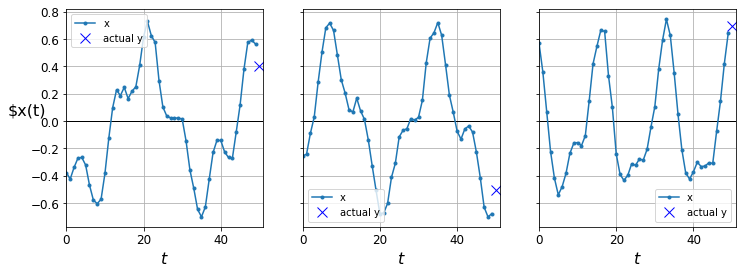

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, sharey = True, figsize = (12, 4))
for col in range(3):
  plt.sca(axes[col])
  plot_series(X_valid[col, :, 0], Y_valid[col, 0], y_label = ("$x(t)" if col == 0 else None))
plt.show()

# **Exercise 1**

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
simple_rnn = keras.models.Sequential([keras.layers.SimpleRNN(1, input_shape = [None, 1])])
simple_rnn.compile(loss = 'mse', optimizer = 'adam')
history = simple_rnn.fit(X_train, Y_train, epochs = 20, validation_data = (X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.2033 - val_loss: 0.1331
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.1000 - val_loss: 0.0863
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0747 - val_loss: 0.0694
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0612 - val_loss: 0.0575
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0516 - val_loss: 0.0489
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0445 - val_loss: 0.0424
Epoch 7/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0391 - val_loss: 0.0374
Epoch 8/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0349 - val_loss: 0.0333
Epoch 9/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0314 - val_loss: 0.0301
Epoch 10/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0286 - val_loss: 0.0274

In [ ]:
simple_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


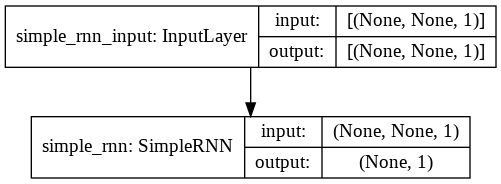

In [ ]:
plot_model(simple_rnn, to_file = "model_shapes.png", show_shapes = True)

In [ ]:
simple_rnn.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0141


0.014119227416813374

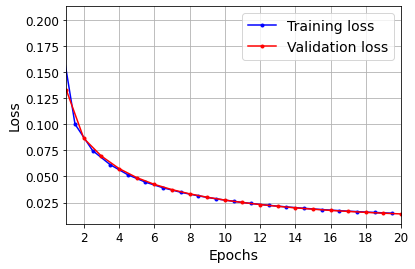

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

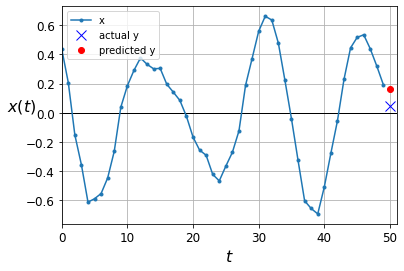

In [ ]:
Y_pred = simple_rnn.predict(X_test)
plot_series(X_test[0, :, 0], Y_test[0, :], Y_pred[0, :])
plt.show()

# **Exercise 2**

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
deep_rnn = keras.models.Sequential([
  keras.layers.SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
  keras.layers.SimpleRNN(20, return_sequences = True),
  keras.layers.SimpleRNN(1)
])
deep_rnn.compile(loss = 'mse', optimizer = 'adam')
history = deep_rnn.fit(X_train, Y_train, epochs = 20, validation_data = (X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 8s 27ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0035 - val_lo

In [ ]:
deep_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


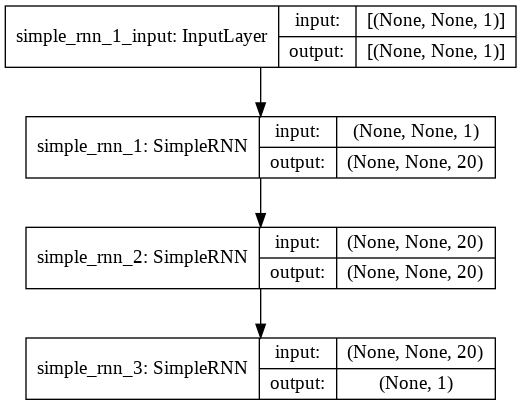

In [ ]:
plot_model(deep_rnn, to_file = "model_shapes.png", show_shapes = True)

In [ ]:
deep_rnn.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 7ms/step - loss: 0.0030


0.003034038469195366

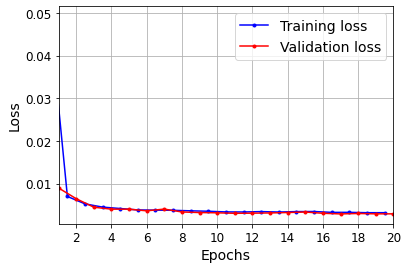

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

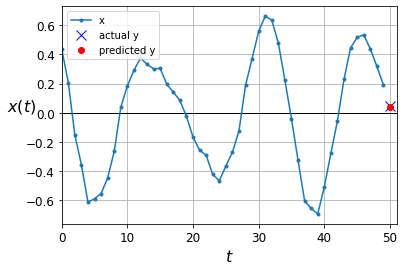

In [ ]:
Y_pred = deep_rnn.predict(X_test)
plot_series(X_test[0, :, 0], Y_test[0, :], Y_pred[0, :])
plt.show()

# **Exercise 3**

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
deep_rnn_dense = keras.models.Sequential([
  keras.layers.SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
  keras.layers.SimpleRNN(20),
  keras.layers.Dense(1)
])
deep_rnn_dense.compile(loss = 'mse', optimizer = 'adam')
history = deep_rnn_dense.fit(X_train, Y_train, epochs = 20, validation_data = (X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 20ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0030 - val_lo

In [ ]:
deep_rnn_dense.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


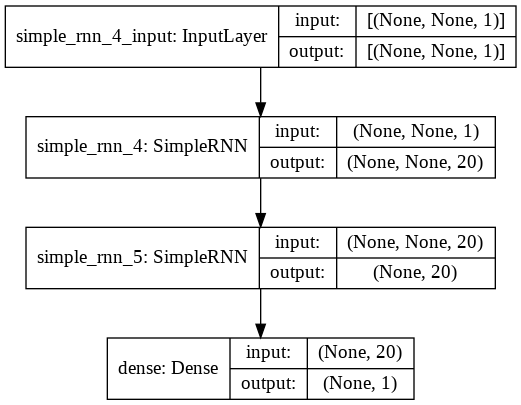

In [ ]:
plot_model(deep_rnn_dense, to_file = "model_shapes.png", show_shapes = True)

In [ ]:
deep_rnn_dense.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0026


0.002623623237013817

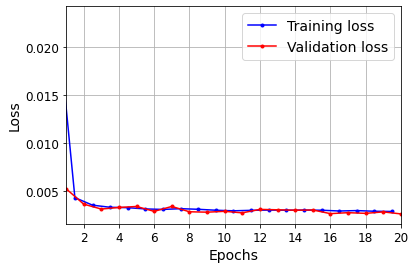

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

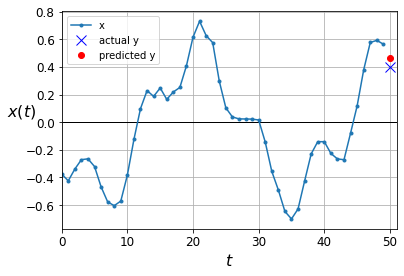

In [ ]:
Y_pred = deep_rnn_dense.predict(X_valid)
plot_series(X_valid[0, :, 0], Y_valid[0, :], Y_pred[0, :])
plt.show()

# **Exercise 4**

**Way 1: Use loop**

In [ ]:
np.random.seed(43)
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
print("Original X shape: ", X.shape)

for step_ahead in range(10):
  print("{}".format(step_ahead), "iteration's X shape: ", X.shape, "used data index :", "{} - {}".format(step_ahead, X.shape[1] - 1))
  Y_pred_one = deep_rnn_dense.predict(X[:, step_ahead:])[:, np.newaxis, :]
  X = np.concatenate([X, Y_pred_one], axis = 1)

Original X shape:  (1, 50, 1)
0 iteration's X shape:  (1, 50, 1) used data index : 0 - 49
1 iteration's X shape:  (1, 51, 1) used data index : 1 - 50
2 iteration's X shape:  (1, 52, 1) used data index : 2 - 51
3 iteration's X shape:  (1, 53, 1) used data index : 3 - 52
4 iteration's X shape:  (1, 54, 1) used data index : 4 - 53
5 iteration's X shape:  (1, 55, 1) used data index : 5 - 54
6 iteration's X shape:  (1, 56, 1) used data index : 6 - 55
7 iteration's X shape:  (1, 57, 1) used data index : 7 - 56
8 iteration's X shape:  (1, 58, 1) used data index : 8 - 57
9 iteration's X shape:  (1, 59, 1) used data index : 9 - 58


In [ ]:
Y_pred = X[:, n_steps:]

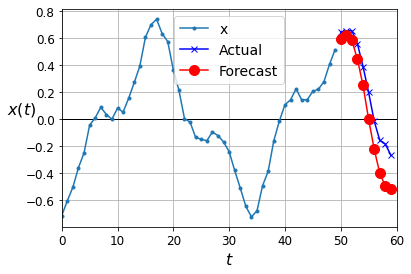

In [ ]:
plot_multiple_forecast(X_new, Y_new, Y_pred)
plt.show()

**Way 2: Use modified Dense layer**

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [ ]:
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

(7000, 50, 1) (7000, 10)
(2000, 50, 1) (2000, 10)
(1000, 50, 1) (1000, 10)


In [ ]:
way2 = keras.models.Sequential([
  keras.layers.SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
  keras.layers.SimpleRNN(20),
  keras.layers.Dense(10)
])
way2.compile(loss = 'mse', optimizer = 'adam')
history = way2.fit(X_train, Y_train, epochs = 1, validation_data = (X_valid, Y_valid))

219/219 [==============================] - 6s 20ms/step - loss: 0.0669 - val_loss: 0.0317


In [ ]:
way2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [ ]:
way2.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 5ms/step - loss: 0.0319


0.03189096227288246

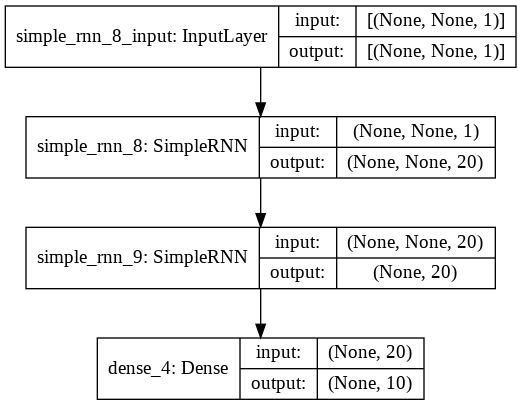

In [ ]:
plot_model(way2, to_file = 'model_shapes.png', show_shapes = True)

In [ ]:
np.random.seed(43)
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = way2.predict(X_new)[..., np.newaxis]

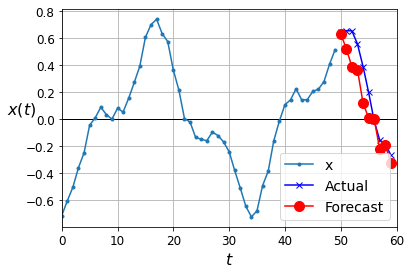

In [ ]:
plot_multiple_forecast(X_new, Y_new, Y_pred)
plt.show()

**Way 3: TimeDistributed Layer**

In [ ]:
def last_time_step_mse(Y_true, Y_pred):
  return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)

X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
  Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

(X_train.shape, Y_train.shape)

((7000, 50, 1), (7000, 50, 10))

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

way3 = keras.models.Sequential([
  keras.layers.SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
  keras.layers.SimpleRNN(20, return_sequences = True),
  keras.layers.TimeDistributed(keras.layers.Dense(10))
])

way3.compile(loss = 'mse', optimizer = 'adam', metrics = [last_time_step_mse])
history = way3.fit(X_train, Y_train, epochs = 20, validation_data = (X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 20ms/step - loss: 0.0742 - last_time_step_mse: 0.0644 - val_loss: 0.0472 - val_last_time_step_mse: 0.0338
Epoch 2/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0441 - last_time_step_mse: 0.0312 - val_loss: 0.0411 - val_last_time_step_mse: 0.0281
Epoch 3/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0397 - last_time_step_mse: 0.0255 - val_loss: 0.0407 - val_last_time_step_mse: 0.0310
Epoch 4/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0375 - last_time_step_mse: 0.0227 - val_loss: 0.0360 - val_last_time_step_mse: 0.0218
Epoch 5/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0357 - last_time_step_mse: 0.0206 - val_loss: 0.0348 - val_last_time_step_mse: 0.0225
Epoch 6/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0344 - last_time_step_mse: 0.0195 - val_loss: 0.0344 - val_last_time_step_mse: 0.0184
Epoch 7/20
219/219 [==

In [ ]:
way3.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 6ms/step - loss: 0.0261 - last_time_step_mse: 0.0117


[0.026098258793354034, 0.011687707155942917]

In [ ]:
np.random.seed(43)
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = way3.predict(X_new)[:, -1][..., np.newaxis]

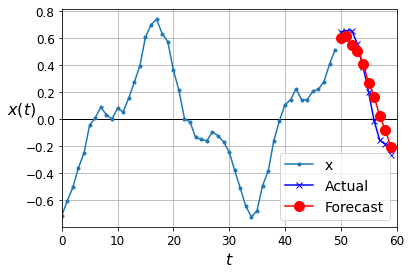

In [ ]:
plot_multiple_forecast(X_new, Y_new, Y_pred)
plt.show()

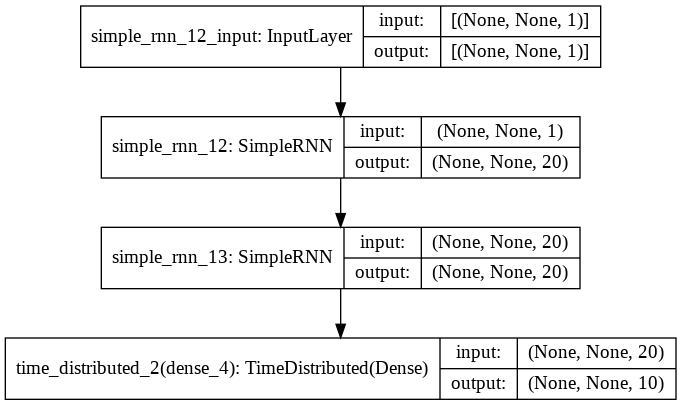

In [ ]:
plot_model(way3, to_file = 'model_shapes.png', show_shapes = True)

# **Exercise 5**

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)

X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
  Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

lstm = keras.models.Sequential([
  keras.layers.LSTM(20, return_sequences = True, input_shape = [None, 1]),
  keras.layers.LSTM(20, return_sequences = True),
  keras.layers.TimeDistributed(keras.layers.Dense(10))
])

lstm.compile(loss = 'mse', optimizer = 'adam', metrics = [last_time_step_mse])
history = lstm.fit(X_train, Y_train, epochs = 20, validation_data = (X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 12s 40ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0480 - last_time_step_mse: 0.0283 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0391 - last_time_step_mse: 0.0181 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0325 - last_time_step_mse: 0.0133 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0308 - last_time_step_mse: 0.0122 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [=

In [ ]:
lstm.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 8ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788681253790855, 0.008560794405639172]

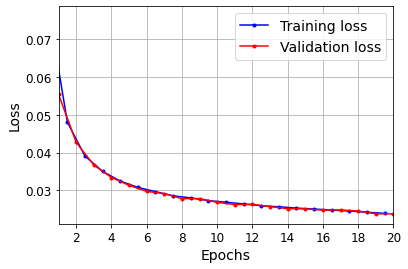

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

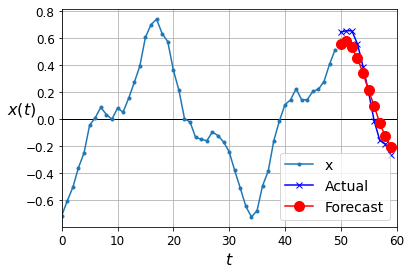

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = lstm.predict(X_new)[:, -1][..., np.newaxis]

plot_multiple_forecast(X_new, Y_new, Y_pred)
plt.show()

# **Exercise 6**

In [ ]:
shakespeare_url = 'https://homl.info/shakespeare'
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
  shakespeare_text = f.read()

1122304/1115394 [==============================] - 0s 0us/step


In [ ]:
print(shakespeare_text[1000:1500])

Second Citizen:
Would you proceed especially against Caius Marcius?

All:
Against him first: he's a very dog to the commonalty.

Second Citizen:
Consider you what services he has done for his country?

First Citizen:
Very well; and could be content to give him good
report fort, but that he pays himself with being proud.

Second Citizen:
Nay, but speak not maliciously.

First Citizen:
I say unto you, what he hath done famously, he did
it to that end: though soft-conscienced men can be
content to 


In [ ]:
len(shakespeare_text)

1115394

In [ ]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level = True)
tokenizer.fit_on_texts(shakespeare_text)

In [ ]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [ ]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [ ]:
tokenizer.texts_to_sequences(["abcde"])

[[5, 22, 19, 13, 2]]

In [ ]:
max_id = len(tokenizer.word_index)
dataset_size = tokenizer.document_count

In [ ]:
max_id, dataset_size

(39, 1115394)

In [ ]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

In [ ]:
train_size = dataset_size  * 40 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [ ]:
n_steps = 100
window_length = n_steps + 1
dataset = dataset.window(window_length, shift = 1, drop_remainder = True)

In [ ]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [ ]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [ ]:
dataset = dataset.map(lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth = max_id), Y_batch))

In [ ]:
dataset = dataset.prefetch(1)

In [ ]:
model = keras.models.Sequential([
  keras.layers.LSTM(64, return_sequences = True, input_shape = [None, max_id], dropout = 0.2, recurrent_dropout = 0),
  keras.layers.LSTM(64, return_sequences = True, dropout = 0.2, recurrent_dropout = 0),
  keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation = 'softmax'))
])
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam')
history = model.fit(dataset, epochs = 5)

Epoch 1/5
13940/13940 [==============================] - 1830s 131ms/step - loss: 1.9824
Epoch 2/5
13940/13940 [==============================] - 1812s 130ms/step - loss: 1.7705
Epoch 3/5
13940/13940 [==============================] - 1814s 130ms/step - loss: 1.7289
Epoch 4/5
13940/13940 [==============================] - 1801s 129ms/step - loss: 1.7092
Epoch 5/5
13940/13940 [==============================] - 1799s 129ms/step - loss: 1.6968


In [ ]:
def preprocess(texts):
  X = np.array(tokenizer.texts_to_sequences(texts)) - 1 
  return tf.one_hot(X, max_id)

In [ ]:
def next_char(text, temperature = 1):
  X_new = preprocess([text])
  Y_proba = model.predict(X_new)[0, -1:, :]
  rescaled_logits = tf.math.log(Y_proba) / temperature
  char_id = tf.random.categorical(rescaled_logits, num_samples = 1) + 1
  return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [ ]:
def complete_text(text, n_chars = 50, temperature = 1):
  for _ in range(n_chars):
    text += next_char(text, temperature)
  return text

In [ ]:
print(complete_text('t', temperature = 0.2))

the word, and the manten the word.

sampson:
i will


In [ ]:
print(complete_text('w', temperature = 0.2))

we are the world,
and they be the word, and the wor


In [ ]:
print(complete_text('w', temperature = 0.8))

will i live.

gregory:
bat guest; or thy death, and


# **Exercise 7**

In [3]:
import keras
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/eepLearning/AIP2_RNN_LAB_Activity/main/Ulsan_Temp.csv")

In [ ]:
df.tail(10)

,Date,Temperature(M),Temperature(L),Temperature(H)
754,2021-05-24,19.6,17.4,24.2
755,2021-05-25,19.0,13.9,24.3
756,2021-05-26,18.3,12.1,23.7
757,2021-05-27,19.1,14.9,24.4
758,2021-05-28,17.5,12.1,26.0
759,2021-05-29,19.3,12.1,25.9
760,2021-05-30,19.2,14.3,24.1
761,2021-05-31,19.0,15.2,25.1
762,2021-06-01,20.3,14.1,25.8
763,2021-06-02,20.9,17.5,26.3


In [5]:
n_steps = 5

temperature = df['Temperature(H)'].values
print(temperature.shape)

(764,)


In [6]:
temperature[:10]

array([23.1, 22.5, 24.4, 25.7, 28.7, 20.2, 20.6, 24.7, 25.7, 25.7])

In [7]:
temperature = temperature[:(temperature.shape[0] // (n_steps + 1)) * (n_steps + 1)].reshape(-1, (n_steps + 1))
r = temperature.shape[0]
r

127

In [8]:
X_train, Y_train = temperature[:int(r * 0.8), :n_steps, np.newaxis], temperature[:int(r * 0.8), -1, np.newaxis]
X_valid, Y_valid = temperature[int(r * 0.8):int(r * 0.9), :n_steps, np.newaxis], temperature[int(r * 0.8):int(r * 0.9), -1, np.newaxis]
X_test, Y_test = temperature[int(r * 0.9):-1, :n_steps, np.newaxis], temperature[int(r * 0.9):-1, -1, np.newaxis]

In [9]:
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

(101, 5, 1) (101, 1)
(13, 5, 1) (13, 1)
(12, 5, 1) (12, 1)


In [10]:
def plot_learning_curves(loss, val_loss):
  plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label = "Training loss")
  plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label = "Validation loss")
  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer = True))
  plt.axis([1, 150, 0, np.max(val_loss) * 1.1])
  plt.legend(fontsize = 14)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.grid(True)

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

# Forecasting Several Steps Ahead, default is 1
steps_ahead = 1

# The number of hidden layers
hidden_layers = 80

# After a lot of trials and errors, I obtain units = 80 that will give the best result
model = keras.models.Sequential([
  # First layer is LSTM.
  keras.layers.LSTM(hidden_layers, return_sequences = True, input_shape = [None, 1]),
  # The two next layer use Simple RNN to advoid over-fitting.
  keras.layers.SimpleRNN(hidden_layers, return_sequences = True),
  keras.layers.SimpleRNN(hidden_layers),
  # The last layer obtains the predicted value.
  keras.layers.Dense(steps_ahead),
])
model.compile(loss = 'mse', optimizer = 'adam')
history = model.fit(X_train, Y_train, epochs = 150, validation_data = (X_valid, Y_valid))

Epoch 1/150
4/4 [==============================] - 26s 458ms/step - loss: 405.2564 - val_loss: 55.3593
Epoch 2/150
4/4 [==============================] - 0s 15ms/step - loss: 284.2544 - val_loss: 47.8285
Epoch 3/150
4/4 [==============================] - 0s 14ms/step - loss: 231.8008 - val_loss: 49.6196
Epoch 4/150
4/4 [==============================] - 0s 14ms/step - loss: 202.6224 - val_loss: 54.5058
Epoch 5/150
4/4 [==============================] - 0s 14ms/step - loss: 173.7700 - val_loss: 60.4660
Epoch 6/150
4/4 [==============================] - 0s 14ms/step - loss: 167.7009 - val_loss: 67.1241
Epoch 7/150
4/4 [==============================] - 0s 21ms/step - loss: 153.2909 - val_loss: 73.9262
Epoch 8/150
4/4 [==============================] - 0s 14ms/step - loss: 143.1022 - val_loss: 79.9617
Epoch 9/150
4/4 [==============================] - 0s 15ms/step - loss: 131.4479 - val_loss: 85.4599
Epoch 10/150
4/4 [==============================] - 0s 14ms/step - loss: 126.0634 - val_l

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 80)          26240     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 80)          12880     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 80)                12880     
_________________________________________________________________
dense (Dense)                (None, 1)                 81        
Total params: 52,081
Trainable params: 52,081
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.evaluate(X_valid, Y_valid)

1/1 [==============================] - 0s 16ms/step - loss: 27.0610


27.061006546020508

In [14]:
model.evaluate(X_test, Y_test)

1/1 [==============================] - 0s 17ms/step - loss: 18.1053


18.10533332824707

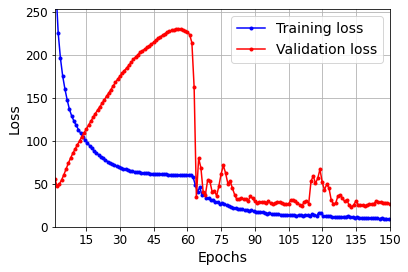

In [15]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

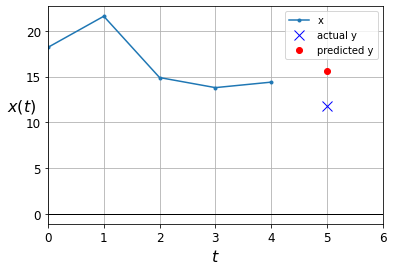

In [16]:
Y_pred = model.predict(X_test)
plot_series(X_test[0, :, 0], Y_test[0, :], Y_pred[0, :])

In [17]:
n_steps = 5
real_temp = np.array([[26], [25.9], [24.1], [25.1], [25.8]]).reshape(1, n_steps, 1)

In [18]:
model.predict(real_temp)

array([[26.247341]], dtype=float32)

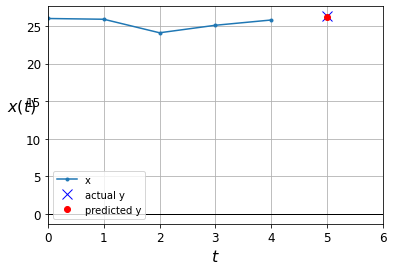

In [19]:
Y_pred = model.predict(real_temp)
plot_series(real_temp[0, :, 0], [26.3], Y_pred[0, :])